In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import multipers as mp
import matplotlib.pyplot as plt
from wrappers import *
from sklearn.pipeline import Pipeline

In [2]:
def orbit(n:int=100, r:float=1., x0=[]):
	point_list=[]
	if len(x0) != 2:
		x,y=np.random.uniform(size=2)
	else:
		x,y = x0
	point_list.append([x,y])
	for _ in range(n-1):
		x = (x + r*y*(1-y)) %1
		y = (y + r*x*(1-x)) %1
		point_list.append([x,y])
	return np.asarray(point_list)

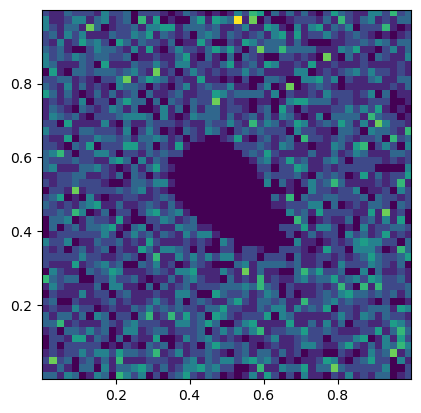

In [3]:
X = orbit(n=5_000, r=4.1)
def show_orbit(X, ax=plt.gca()):
    heatmap, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=50, density = 1)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T, origin='lower', extent=extent)
show_orbit(X)

In [4]:
rs = [2.5, 3.5, 4, 4.1, 4.3]
labels = np.random.choice(rs, size=10, replace=True)
X = [orbit(n=1000, r=r) for r in labels]

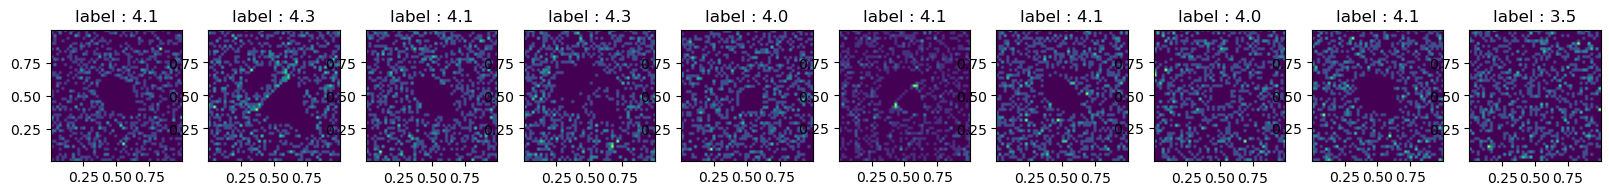

In [5]:
scale=20
fig, axes = plt.subplots(1,len(labels), figsize=(scale, scale*len(labels)))
for ax, x, l in zip(axes, X, labels):
    show_orbit(x, ax=ax)
    ax.set_title(f"label : {l}")

In [6]:
rips_threshold = 0.5
res = 50
filtration_grid = [np.linspace(0,rips_threshold,num=res), np.linspace(0,1,num=res)]
rips = RipsDensity2SimplexTree(bandwidth=0.01, rescale_density=1, num_collapse=0, threshold=rips_threshold, sparse=None, delayed=True)
sm = SimplexTree2SignedMeasure(filtration_grid = filtration_grid, degrees=[0], progress=1, n_jobs=5, num_collapses=100)
vect = SignedMeasure2img(filtration_grid=filtration_grid, bandwidth=.1)
signed_measure_pipe = Pipeline([
    ("rips", rips),
    ("sm", sm),
    ("vect", vect)

])
imgs = signed_measure_pipe.fit_transform(X)

Computing Hilbert function: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Removing edges:   9%|▉         | 9/100 [00:03<00:30,  2.95it/s]


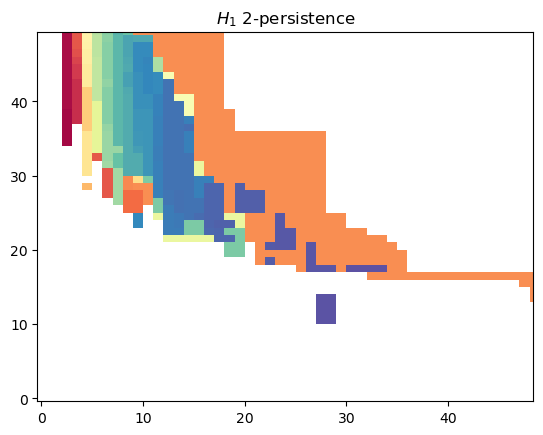

In [7]:
## Just to check the rank invariant underneath
rips_copy = rips
rips_copy.delayed=False
from random import choice
st, = rips_copy.fit_transform([choice(X)])
st.grid_squeeze(filtration_grid=filtration_grid, coordinate_values=True)
st.collapse_edges(num=100, progress=1)
st.expansion(2)
mod = st.persistence_approximation().plot(degree=1)

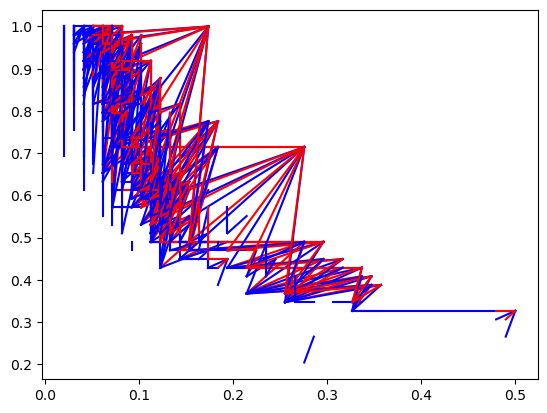

In [8]:
rank_tensor = mp.rank_invariant2d(simplextree=st, grid_shape=[res,res],degree=1)
rectangle_decompo = rank_decomposition_by_rectangles(rank_tensor)
rectangle_decompo = tensor_to_rectangle(rectangle_decompo, plot=True, grid_conversion=np.asarray(filtration_grid))

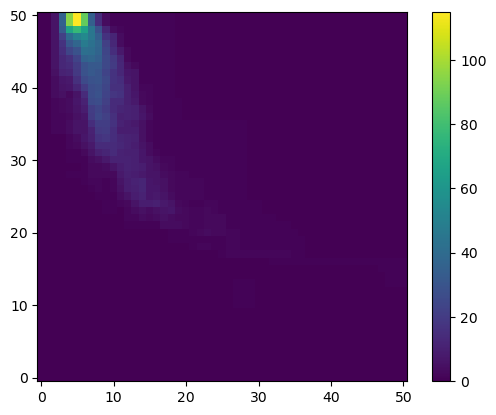

In [9]:
hilbert = mp.hilbert2d(st, grid_shape=[res+1,res+1],degree=1)
plt.imshow(hilbert.T, origin="lower")
plt.colorbar()

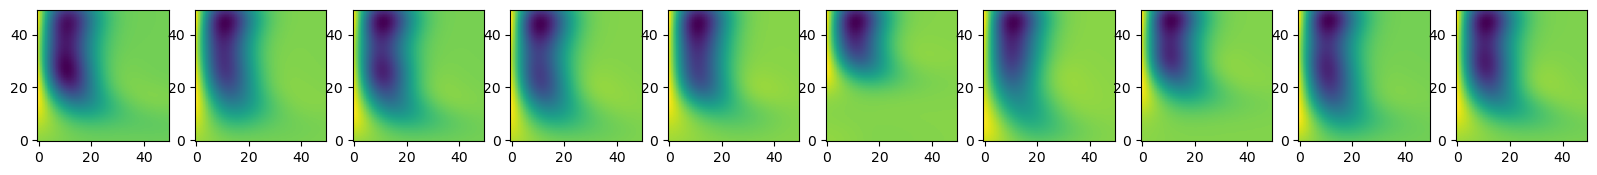

In [10]:
fig, axes = plt.subplots(1,len(labels), figsize=(scale, scale*len(labels)))
for ax,img in zip(axes, imgs):
    ax.imshow(img.T, origin="lower")